This file uses .edf file as data source

# EDF data processing

Extracting EDF parameters from /Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/sample_data/E23B6B24FX14_1743527027000/E23B6B24FX14_1743527027000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1911124  =      0.000 ... 15288.992 secs...
Reading 0 ... 1911124  =      0.000 ... 15288.992 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: LF-FpZ, OTE_L-FpZ, RF-FpZ, OTE_R-FpZ
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: 2025-04-02 00:03:46 UTC
 nchan: 4
 projs: []
 sfreq: 125.0 Hz
 subject_info: 3 items (dict)
>
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
<Info | 8 non-empty values
 bads: []
 ch_names: LF-FpZ, OTE_L-FpZ, RF-FpZ, OTE_R-FpZ
 chs: 4 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: 2025-04-02 00:03:46 UTC
 ncha

/var/folders/f5/c36xrqx57d11z837zkq5q8580000gn/T/ipykernel_65323/2709848989.py:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd()
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


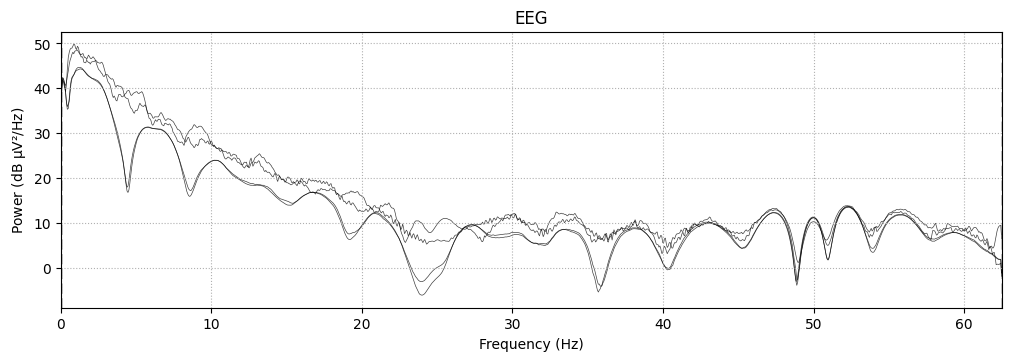

In [6]:
import mne
from mne.preprocessing import ICA

EDF_FILE = "sample_data/E23B6B24FX14_1743527027000/E23B6B24FX14_1743527027000.edf"
DAT_FILE = "sample_data/E23B6B24FX14_1743527027000/E23B6B24FX14_1743527027000.dat"
SLEEP_STAGE_CSV_FILE = "sample_data/E23B6B24FX14_1743527027000/E23B6B24FX14_1743527027000.csv"
SIGNAL_QUAL_CSV_FILE = "sample_data/E23B6B24FX14_1743527027000/E23B6B24FX14_1743527027000_SQC.csv"

raw = mne.io.read_raw_edf(
    EDF_FILE, preload=True)


print(raw.info)
raw.plot_psd()

Effective window size : 16.384 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


/var/folders/f5/c36xrqx57d11z837zkq5q8580000gn/T/ipykernel_65323/4108630121.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


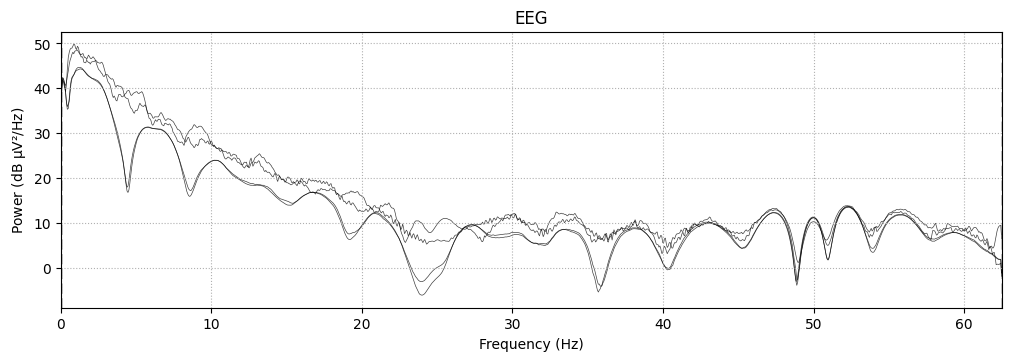

In [7]:
raw.compute_psd().plot()

In [8]:
raw.filter(l_freq=0.5, h_freq=40)
raw.notch_filter(freqs=60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (6.600 s)

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 1

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


<RawEDF | E23B6B24FX14_1743527027000.edf, 4 x 1911125 (15289.0 s), ~58.3 MB, data loaded>

Effective window size : 16.384 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


/var/folders/f5/c36xrqx57d11z837zkq5q8580000gn/T/ipykernel_65323/4108630121.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


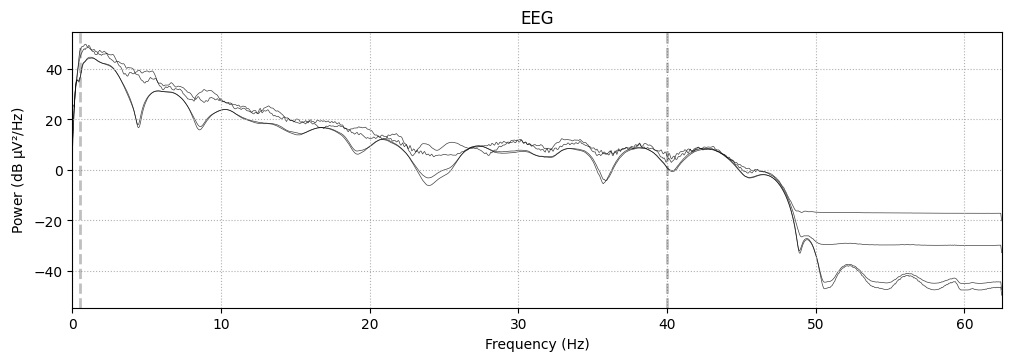

In [9]:
raw.compute_psd().plot()

## Detect whether the frequency has been influenced by the EOG and EMG

Effective window size : 16.384 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


/var/folders/f5/c36xrqx57d11z837zkq5q8580000gn/T/ipykernel_65323/3623999173.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmin=30, fmax = 60).plot()
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


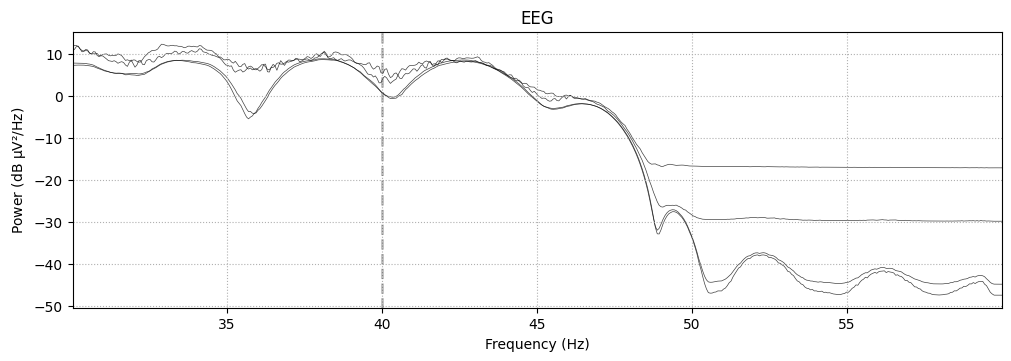

In [10]:
raw.compute_psd(fmin=30, fmax = 60).plot()

## Use ICA filter to remove the EOG

Fitting ICA to data using 4 channels (please be patient, this may take a while)
Selecting by number: 4 components
Selecting by number: 4 components
Fitting ICA took 2.7s.
Fitting ICA took 2.7s.
Creating RawArray with float64 data, n_channels=4, n_times=1911125
    Range : 0 ... 1911124 =      0.000 ... 15288.992 secs
Ready.
Using matplotlib as 2D backend.
Creating RawArray with float64 data, n_channels=4, n_times=1911125
    Range : 0 ... 1911124 =      0.000 ... 15288.992 secs
Ready.
Using matplotlib as 2D backend.


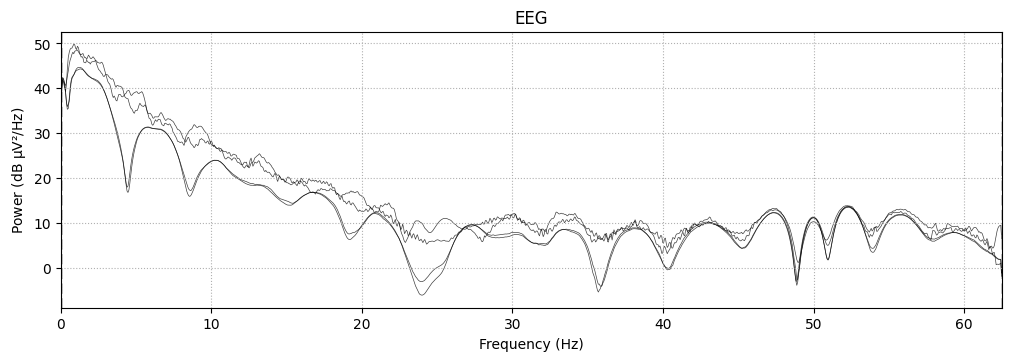

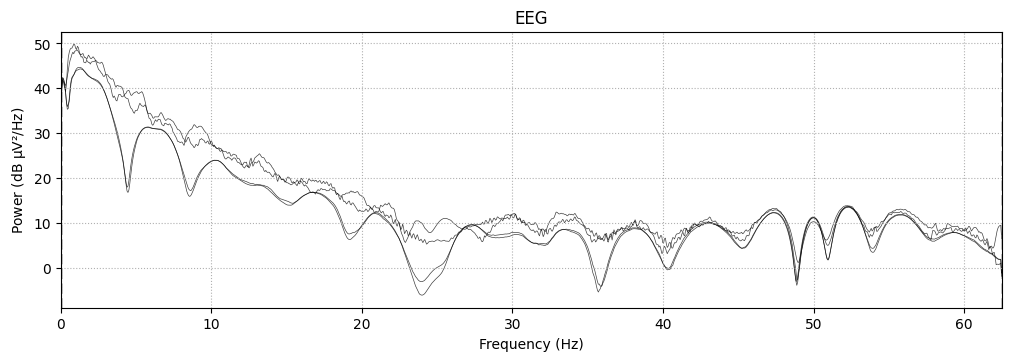

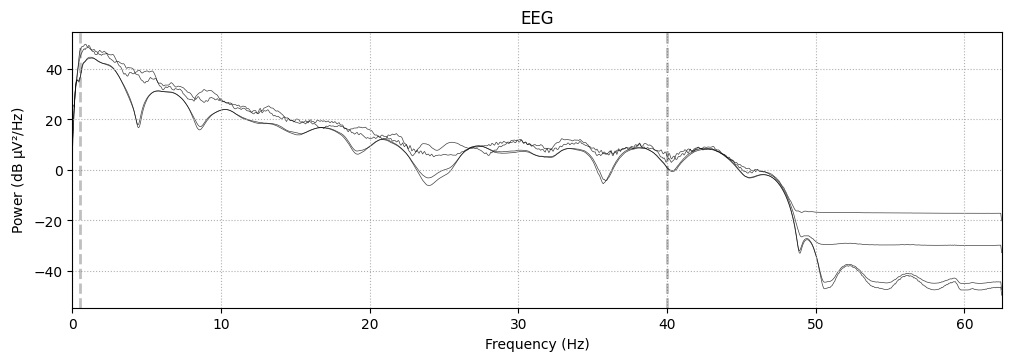

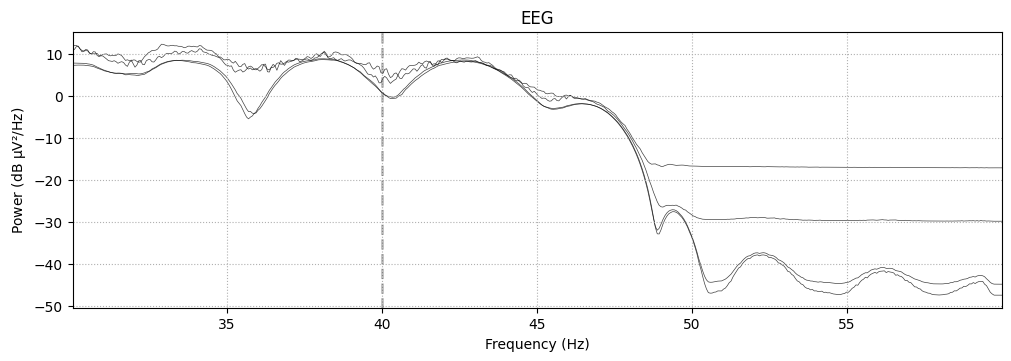

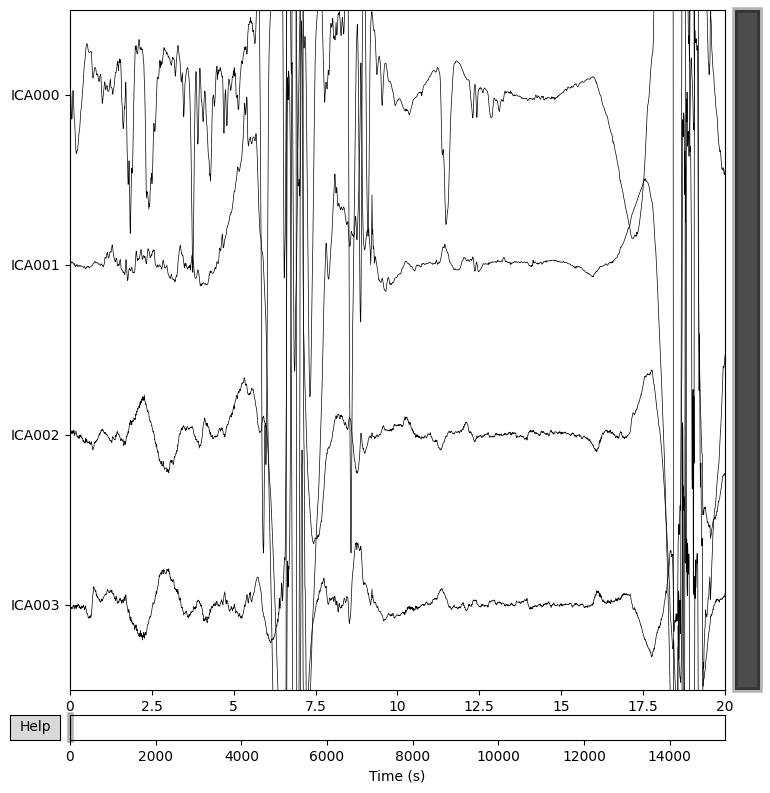

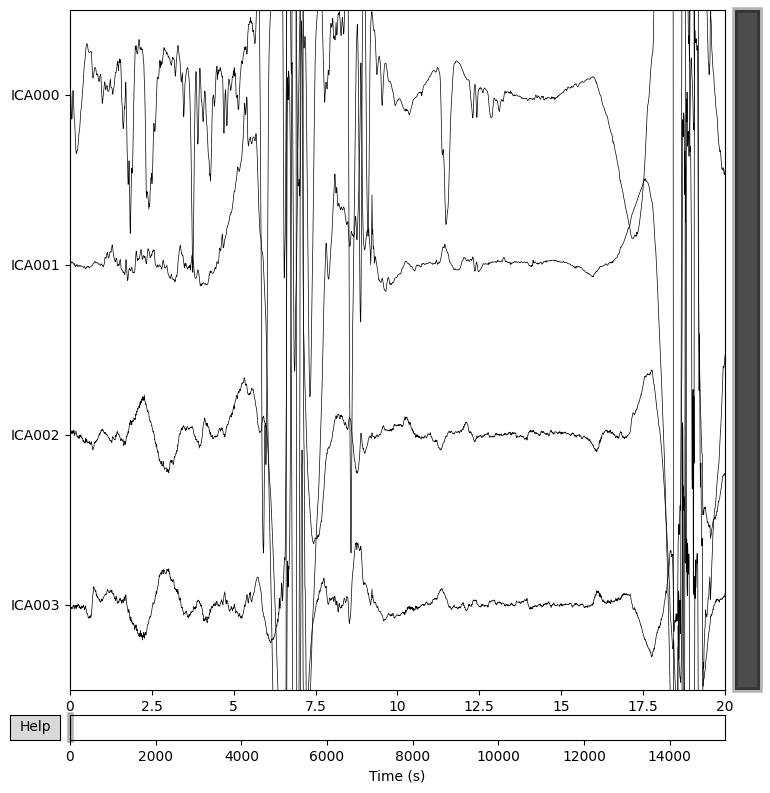

In [11]:
ica = ICA(n_components=4, random_state=97)
ica.fit(raw)
ica.plot_sources(raw)

## ICA clean process

In [12]:
ica.exclude = [0, 1]

ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 2 ICA components
    Projecting back using 4 PCA components
    Transforming to ICA space (4 components)
    Zeroing out 2 ICA components
    Projecting back using 4 PCA components


<RawEDF | E23B6B24FX14_1743527027000.edf, 4 x 1911125 (15289.0 s), ~58.3 MB, data loaded>

Effective window size : 16.384 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


/var/folders/f5/c36xrqx57d11z837zkq5q8580000gn/T/ipykernel_65323/2327585885.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  psd.plot()
/Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/.venv/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


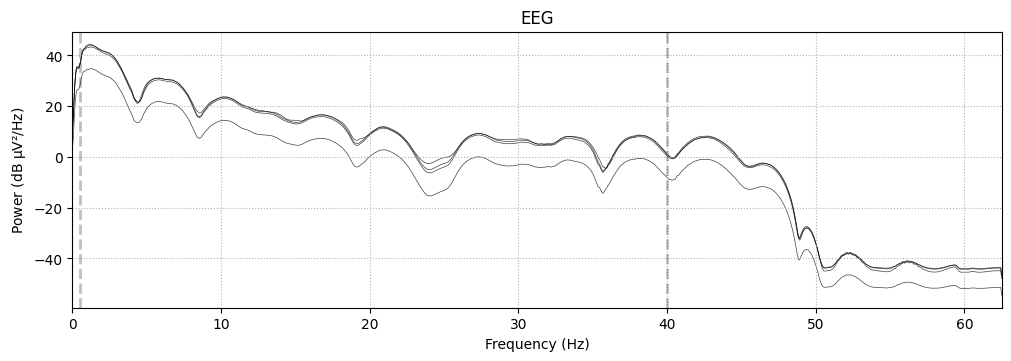

In [13]:
psd = raw.compute_psd()
psd.plot()

# Sliding Window Based Feature Extraction for Alertness

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_welch
from sklearn.preprocessing import MinMaxScaler
raw.info["ch_names"]

['LF-FpZ', 'OTE_L-FpZ', 'RF-FpZ', 'OTE_R-FpZ']

In [15]:
from mne.utils import use_log_level
mne.set_log_level('ERROR')


In [16]:
tp = raw.get_data()

In [17]:
tp[:2]

array([[ 1.13310410e-10, -1.03639890e-05, -1.52986650e-05, ...,
        -8.76939231e-10, -7.92401004e-11,  1.13310409e-10],
       [ 1.02759843e-08,  8.22105644e-07, -9.06363751e-06, ...,
         1.00677999e-08,  1.01304367e-08,  1.02759843e-08]])

In [18]:
data = raw.get_data()  # shape: [n_channels, n_times]

sfreq = raw.info['sfreq']

win_sec = 2.5 # window length in seconds
step_sec = 1 # step size in seconds

n_win_samples = int(win_sec * sfreq)
n_step_samples = int(step_sec * sfreq)

features_over_time = []

for start in range(0, data.shape[1] - n_win_samples, n_step_samples):
    segment = data[:, start:start + n_win_samples]
    with use_log_level("ERROR"):
        psds, freqs = psd_array_welch(segment, sfreq=sfreq, fmin=1, fmax=40, n_fft=256)

    theta = psds[:, (freqs >= 4) & (freqs <= 8)].mean(axis=1)
    alpha = psds[:, (freqs >= 8) & (freqs <= 12)].mean(axis=1)
    beta  = psds[:, (freqs >= 13) & (freqs <= 30)].mean(axis=1)

    alpha_theta_ratio = alpha / (theta)
    beta_theta_ratio = beta / (theta)

    features_over_time.append({
        "start_time": start / sfreq,
        "theta": theta.mean(),
        "alpha": alpha.mean(),
        "beta": beta.mean(),
        "alpha_theta_ratio": alpha_theta_ratio.mean(),
        "beta_theta_ratio": beta_theta_ratio.mean()
    })


In [19]:
df_time_features = pd.DataFrame(features_over_time)

In [20]:
df_time_features[0:10]

,start_time,theta,alpha,beta,alpha_theta_ratio,beta_theta_ratio
0,0.0,1.776689e-11,4.893257e-12,8.534266e-13,0.296109,0.054598
1,1.0,6.820548e-12,7.949129e-12,1.988029e-12,1.118477,0.283211
2,2.0,5.804182e-12,3.142052e-12,8.321086e-13,0.521996,0.142443
3,3.0,2.627643e-11,4.123708e-12,1.176055e-12,0.158812,0.044871
4,4.0,9.425146e-12,1.569404e-11,3.533274e-12,1.527293,0.366686
5,5.0,4.846112e-09,1.006733e-09,5.815086e-11,0.202537,0.011854
6,6.0,1.027997e-07,2.024590e-08,6.206930e-10,0.192170,0.005900
7,7.0,3.775937e-10,9.179907e-11,5.101868e-12,0.234164,0.013865
8,8.0,2.681695e-10,4.308663e-11,1.828937e-12,0.158777,0.007045
9,9.0,4.694702e-12,1.144654e-12,1.937511e-13,0.245386,0.041360


In [21]:
df = df_time_features.copy()

df['alpha_theta_smooth'] = df['alpha_theta_ratio'].rolling(window=3).mean()
df['beta_theta_smooth']  = df['beta_theta_ratio'].rolling(window=3).mean()


# df['alert'] = (df['alpha_theta_smooth'] > 0.4) & (df['beta_theta_smooth'] > 0.3)
# df['alert_int'] = df['alert'].astype(float)
# # df['alertness_score'] = df['alert'].rolling(window=50, min_periods=1).mean()
# df['alertness_score_ema'] = df['alert_int'].ewm(span=10, adjust=False).mean()

df['alpha_theta_score'] = df['alpha_theta_smooth'].clip(0.2, 0.6)
df['alpha_theta_score'] = (df['alpha_theta_score'] - 0.2) / (0.6 - 0.2)

df['beta_theta_score'] = df['beta_theta_smooth'].clip(0.2, 0.6)
df['beta_theta_score'] = (df['beta_theta_score'] - 0.2) / (0.6 - 0.2)

# Combine both scores
df['alertness_score'] = (df['alpha_theta_score'] + df['beta_theta_score']) / 2

# Final EMA score
df['alertness_score_ema'] = df['alertness_score'].ewm(span=100, adjust=True).mean()


## Read sleep stage data (.csv) for alertness score qualification

In [27]:
file_path = SLEEP_STAGE_CSV_FILE
sleep_data = pd.read_csv(file_path)

print(sleep_data.head())

    Timestamp Sleep stage
0  1743527035        Wake
1  1743527065        Wake
2  1743527095        Wake
3  1743527125        Wake
4  1743527155        Wake


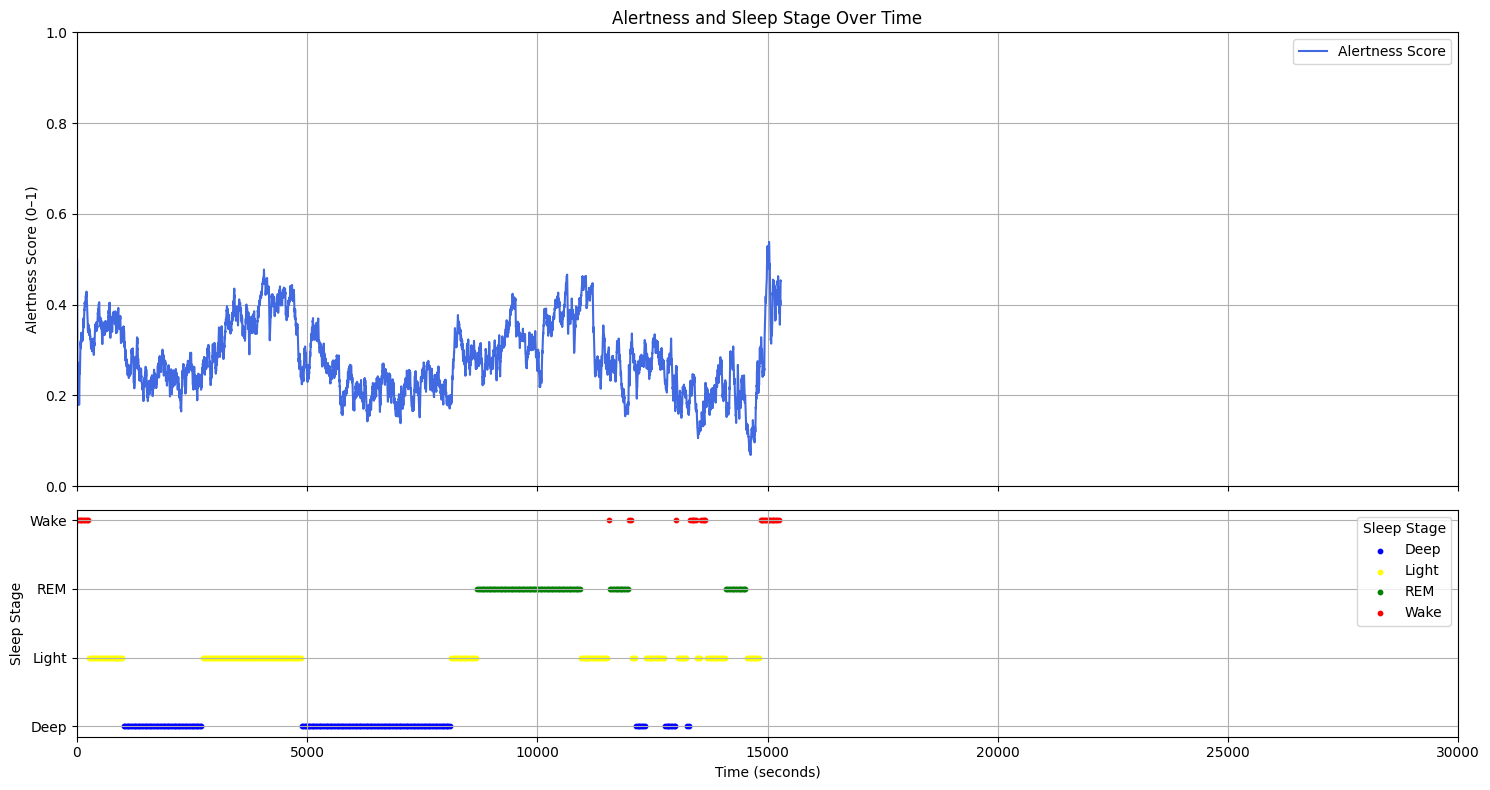

In [29]:
import matplotlib.pyplot as plt

start_time = 0
end_time = 30000

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8), gridspec_kw={'height_ratios': [2, 1]})

# ==== Alertness Score ====
ax1.plot(df['start_time'], df['alertness_score_ema'], linestyle='-', color='royalblue', label='Alertness Score')
ax1.set_ylabel("Alertness Score (0–1)")
ax1.set_title("Alertness and Sleep Stage Over Time")
ax1.set_ylim(0, 1)
ax1.grid(True)
ax1.legend(loc='upper right')

# ==== Sleep Stage ====
sleep_data['Relative Time'] = (sleep_data['Timestamp'] - sleep_data['Timestamp'].iloc[0])

stage_colors = {
    'Deep': 'blue',
    'Light': 'yellow',
    'REM': 'green',
    'Wake': 'red'
}

for stage, color in stage_colors.items():
    stage_data = sleep_data[sleep_data['Sleep stage'] == stage]
    ax2.scatter(stage_data['Relative Time'], [stage] * len(stage_data), color=color, label=stage, s=10)

ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Sleep Stage")
ax2.legend(title='Sleep Stage', loc='upper right')
ax2.grid(True)

ax1.set_ylim(0, 1)
ax2.set_xlim(start_time, end_time)

plt.tight_layout()
plt.show()


# Machine Learning Model

In [ ]:
sleep_series = sleep_data['Sleep stage'].reset_index(drop=True)

win_sec, step_sec = 3, 1
n_win, n_step = int(win_sec*sfreq), int(step_sec*sfreq)
feat_list, label_list = [], []

for st in range(0, data.shape[1] - n_win, n_step):
    seg = data[:, st:st+n_win]
    psd, f = psd_array_welch(seg, sfreq, fmin=0.5, fmax=40,
                             n_fft=n_win)   # <= 关键
    
    band = lambda lo, hi: psd[:, (f >= lo) & (f < hi)].mean(axis=1).mean()
    
    alpha, theta = band(8,12), band(4,8)
    beta,  gamma = band(13,30), band(30,40)
    delta = band(0.5,4)

    epoch_idx = int((st / sfreq) // 30)
    if epoch_idx >= len(sleep_series):
        break                       # 已经没有对应的 30 s 注释，停止循环

    stage = sleep_series.iloc[epoch_idx]
    if stage == 'Wake':
        label = 0.9
    elif stage == 'Deep':
        label = 0.1
    elif stage == 'REM':
        label = 0.65
    elif stage == 'Light':
        label = 0.35
    else:
        label = np.nan              # Light / REM 等

    features = [
        alpha, beta, theta, gamma, delta,
        alpha/theta, beta/theta, beta/alpha,
        (beta+gamma)/(alpha+theta),
        theta/(alpha+beta)
    ]
    feat_list.append(features)
    label_list.append(label)



In [ ]:
feature_names = [
    'alpha', 'beta', 'theta', 'gamma', 'delta',
    'alpha_theta', 'beta_theta', 'beta_alpha',
    'high_low', 'theta_over_alpha_beta'
]

df_feat = pd.DataFrame(feat_list, columns=feature_names)
df_feat['label'] = label_list   

train_df = df_feat.dropna(subset=['label']).reset_index(drop=True)
X = train_df[feature_names].values
y = train_df['label'].values.astype(float)

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.round()
)

In [ ]:
import lightgbm as lgb
lgb_reg = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    objective='regression'
)
lgb_reg.fit(X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='l2'
            )
print("Val R²:", lgb_reg.score(X_val, y_val))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 23424, number of used features: 10
[LightGBM] [Info] Start training from score 0.473990
Val R²: 0.5697825934363522


/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(lgb_reg, X, y, cv=cv, scoring='neg_mean_squared_error')
print("5-fold CV RMSE:", np.sqrt(-cv_scores).mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 23424, number of used features: 10
[LightGBM] [Info] Start training from score 0.474347


/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 23424, number of used features: 10
[LightGBM] [Info] Start training from score 0.473960


/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 23424, number of used features: 10
[LightGBM] [Info] Start training from score 0.474763


/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 23424, number of used features: 10
[LightGBM] [Info] Start training from score 0.475280


/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 23424, number of used features: 10
[LightGBM] [Info] Start training from score 0.472295
5-fold CV RMSE: 0.16852223958900844


/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
X_all = df_feat[feature_names].values
pred_alert = lgb_reg.predict(X_all)                 # 0–1 连续值
df_feat['alert_pred'] = pred_alert
df_feat['alert_pred_ema'] = df_feat['alert_pred'].ewm(span=5, adjust=False).mean()

/opt/anaconda3/envs/frenz-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


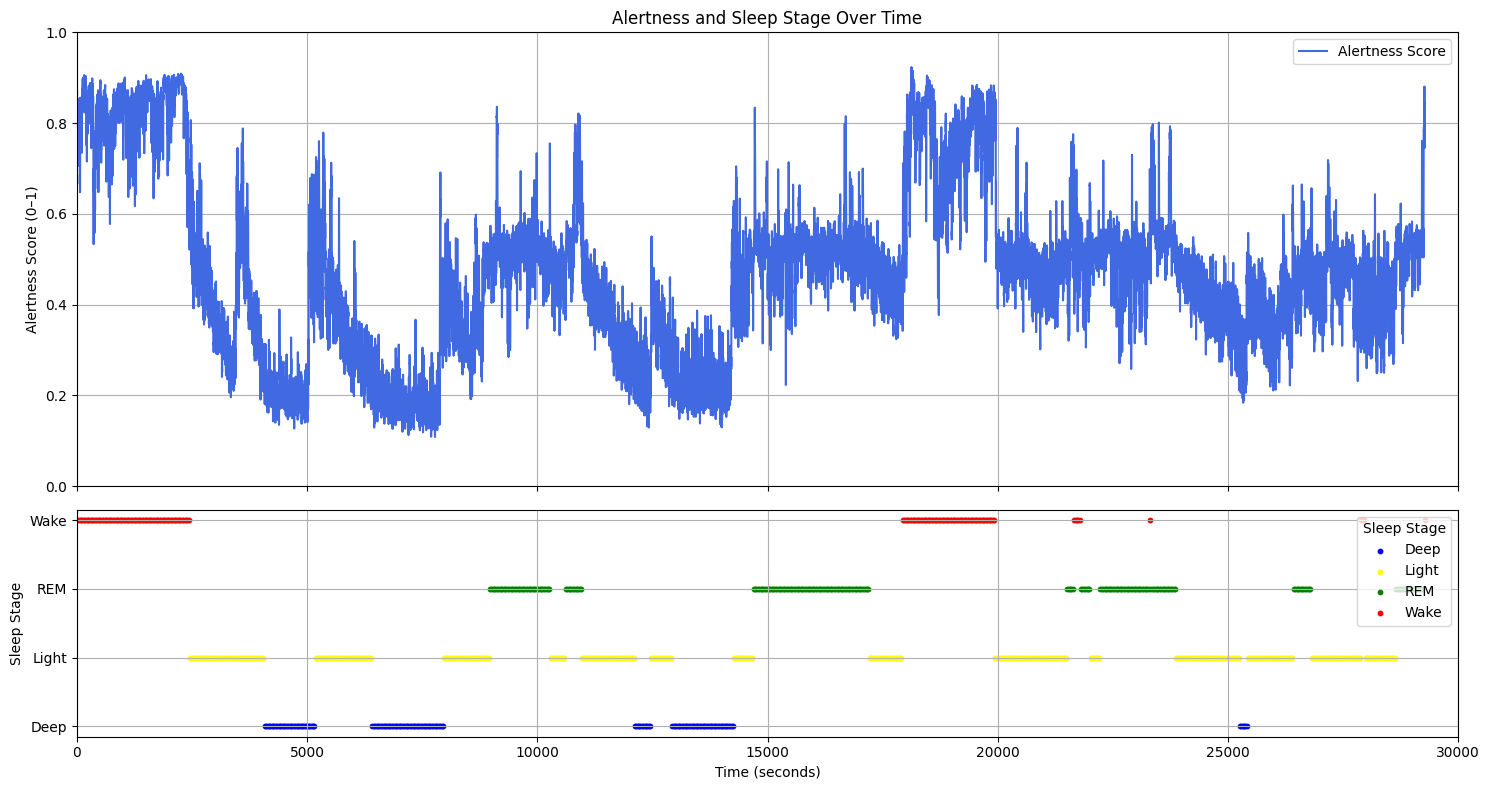

In [ ]:
import matplotlib.pyplot as plt

start_time = 0000
# start_time = 12400
# end_time = 100
end_time = 30000

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8), gridspec_kw={'height_ratios': [2, 1]})

# ==== Alertness Score ====
ax1.plot(df_feat['alert_pred_ema'], linestyle='-', color='royalblue', label='Alertness Score')
ax1.set_ylabel("Alertness Score (0–1)")
ax1.set_title("Alertness and Sleep Stage Over Time")
ax1.set_ylim(0, 1)
ax1.grid(True)
ax1.legend(loc='upper right')

# ==== Sleep Stage ====
sleep_data['Relative Time'] = (sleep_data['Timestamp'] - sleep_data['Timestamp'].iloc[0])  

stage_colors = {
    'Deep': 'blue',
    'Light': 'yellow',
    'REM': 'green',
    'Wake': 'red'
}

for stage, color in stage_colors.items():
    stage_data = sleep_data[sleep_data['Sleep stage'] == stage]
    ax2.scatter(stage_data['Relative Time'], [stage] * len(stage_data), color=color, label=stage, s=10)

ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Sleep Stage")
ax2.legend(title='Sleep Stage', loc='upper right')
ax2.grid(True)

ax1.set_ylim(0, 1)
ax2.set_xlim(start_time, end_time)

plt.tight_layout()
plt.show()